In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns

import os
from datetime import datetime
from tqdm import tqdm

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest

from yellowbrick.cluster import KElbowVisualizer

In [2]:
# assign path
path, dirs, files = next(os.walk("data/halfhourly_dataset/"))
file_count = len(files)
df_list = []

#blocks with problems: 51 12 33 13 19 108 9
files = ["block_0.csv", "block_1.csv", "block_2.csv"]
file_count = 3

# append datasets to the list 
for i in tqdm(range(file_count)):
    temp_df = pd.read_csv("data/halfhourly_dataset/"+files[i], low_memory=False)
    df_list.append(temp_df)
    
df = pd.concat(df_list)

#read weather file
df_weather = pd.read_csv("data/weather_daily_darksky.csv", low_memory=False)


100%|█████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.00s/it]


In [3]:
#Remover Nulls
df = df.dropna()

In [4]:
df.columns = ['house', 'time', 'energy']

df['time'] = pd.to_datetime(df['time'], errors='coerce')
df_weather['temperatureMaxTime'] = pd.to_datetime(df_weather['temperatureMaxTime'], errors='coerce')

#We will work with only the year 2013 to make things easier
df = df[df['time'].dt.isocalendar().year == 2013]
df = df[df['time'].dt.strftime('%Y-%m-%d') != '2012-12-31']

df_weather = df_weather[df_weather['temperatureMaxTime'].dt.isocalendar().year == 2013]
df_weather = df_weather[df_weather['temperatureMaxTime'].dt.strftime('%Y-%m-%d') != '2012-12-31']
df_weather = df_weather

df['house'] = df['house'].astype(str)
df['energy'] = pd.to_numeric(df['energy'], errors='coerce')

In [5]:
print(df.describe(include = 'all', datetime_is_numeric=True))
df_weather = df_weather.iloc[:,[0,1]]
df_weather = df_weather.reset_index()


            house                           time        energy
count     2478012                        2478012  2.478011e+06
unique        148                            NaN           NaN
top     MAC000002                            NaN           NaN
freq        17424                            NaN           NaN
mean          NaN  2013-06-29 02:32:05.712538624  3.913473e-01
min           NaN            2013-01-01 00:00:00  0.000000e+00
25%           NaN            2013-03-30 12:00:00  1.170000e-01
50%           NaN            2013-06-28 00:30:00  2.210000e-01
75%           NaN            2013-09-27 02:00:00  4.640000e-01
max           NaN            2013-12-29 23:30:00  9.141000e+00
std           NaN                            NaN  4.781310e-01


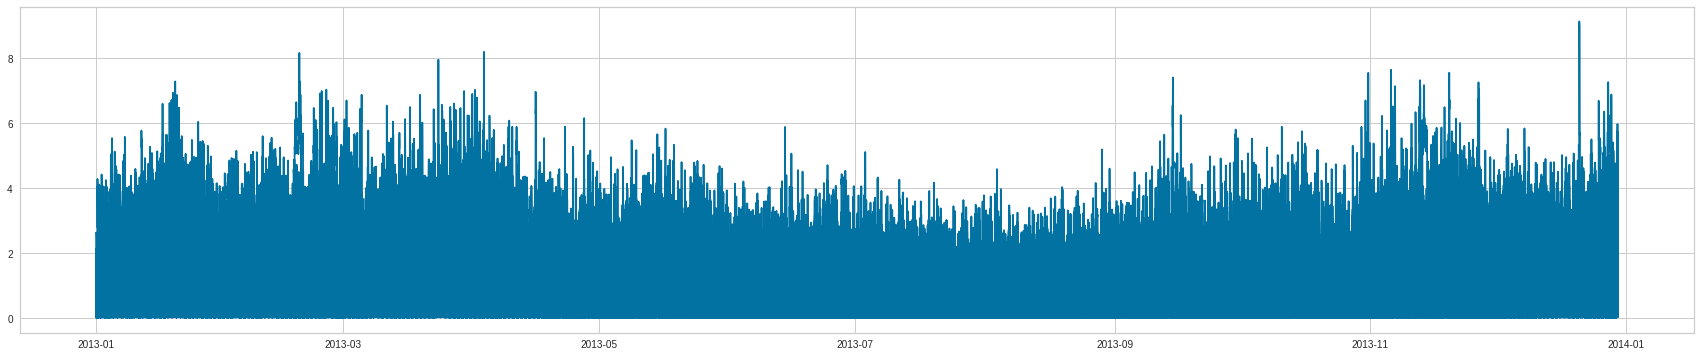

In [6]:
fig = plt.subplots(figsize =(30, 6))
plt.plot(df['time'], df['energy'])
plt.show()

In [7]:
# the hours and if it's night or day (7:00-22:00)
#df['hours'] = df['time'].dt.hour
df['daylight'] = ((df['time'].dt.hour >= 7) & (df['time'].dt.hour <= 22)).astype(int)

In [8]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['time'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)

In [9]:
# creation of 4 distinct categories
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0] # WeekEnd Night
b = df.loc[df['categories'] == 1] # WeekEnd Day
c = df.loc[df['categories'] == 2] # WeekDay Night
d = df.loc[df['categories'] == 3] # WeekDay Day
#print(a)

a = a.groupby(['house', pd.Grouper(key='time', freq='W-MON')])['energy'].sum().reset_index().sort_values(['house', 'time'])
b = b.groupby(['house', pd.Grouper(key='time', freq='W-MON')])['energy'].sum().reset_index().sort_values(['house', 'time'])
c = c.groupby(['house', pd.Grouper(key='time', freq='W-MON')])['energy'].sum().reset_index().sort_values(['house', 'time'])
d = d.groupby(['house', pd.Grouper(key='time', freq='W-MON')])['energy'].sum().reset_index().sort_values(['house', 'time'])
#print(a)

a = a.groupby(['time'])['energy'].mean().reset_index().sort_values('time')
b = b.groupby(['time'])['energy'].mean().reset_index().sort_values('time')
c = c.groupby(['time'])['energy'].mean().reset_index().sort_values('time')
d = d.groupby(['time'])['energy'].mean().reset_index().sort_values('time')
#print(a)

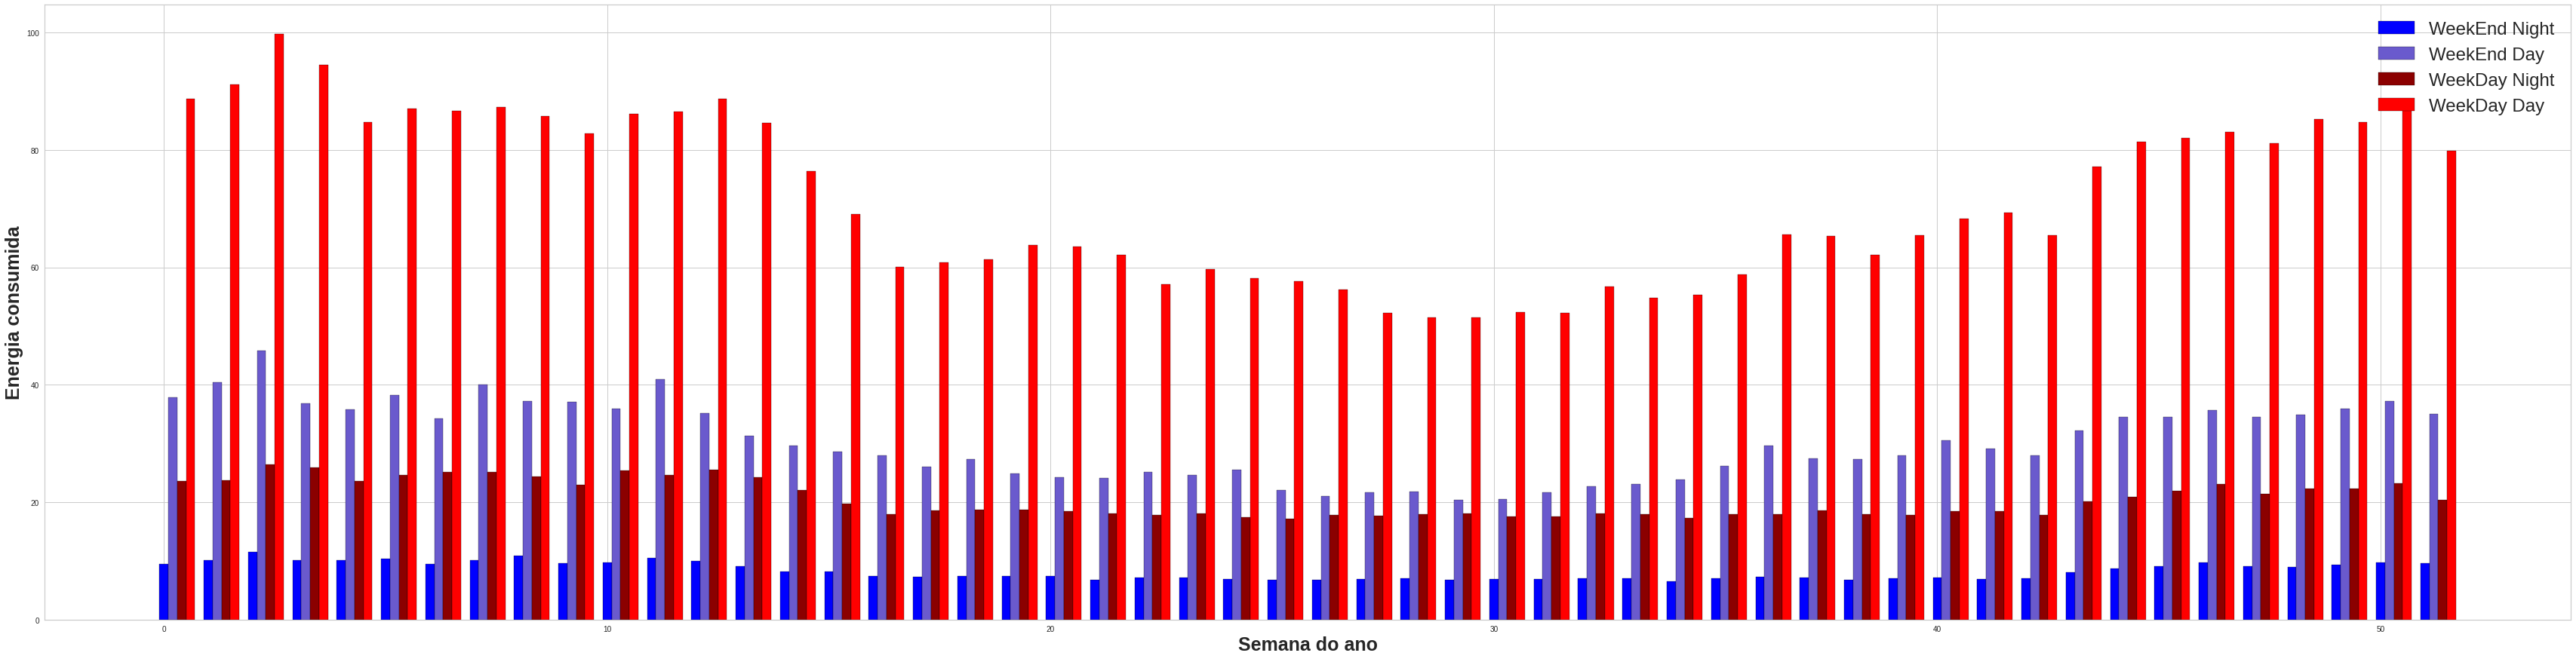

In [10]:
# set width of bar
barWidth = 0.20
fig = plt.subplots(figsize =(60, 15))

weeks = list(range(1, 52))
label=['WeekEnd Night', 'WeekEnd Day', 'WeekDay Night', 'WeekDay Day']
 
# Set position of bar on X axis
br1 = np.arange(len(a))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
 
# Make the plot
plt.bar(br1, a['energy'], color ='blue', width = barWidth,
        edgecolor ='black', label ='WeekEnd Night')

plt.bar(br2, b['energy'], color ='slateblue', width = barWidth,
        edgecolor ='black', label ='WeekEnd Day')

plt.bar(br3, c['energy'], color ='darkred', width = barWidth,
        edgecolor ='black', label ='WeekDay Night')

plt.bar(br4, d['energy'], color ='red', width = barWidth,
        edgecolor ='black', label ='WeekDay Day')
 
# Adding Xticks
plt.xlabel('Semana do ano', fontweight ='bold', fontsize = 25)
plt.ylabel('Energia consumida', fontweight ='bold', fontsize = 25)
#plt.xticks([r + barWidth for r in range(len(a))],
#        weeks)
 
plt.legend(loc='upper right', prop={'size': 24})
plt.show()
#lux mais cara durante o dia
#grafico preço e gasto depois

In [12]:
#usar temp média

df_days = df.groupby(['house', pd.Grouper(key='time', freq='D')])['energy'].sum().reset_index().sort_values(['house', 'time'])
print(df_days)
splits = list(df_days.groupby("house"))
df_days = df_days.groupby(['time'])['energy'].mean().reset_index().sort_values('time')

#passar para data para poder dar merge
df_weather['temperatureMaxTime'] = pd.to_datetime(df_weather['temperatureMaxTime']).dt.date
df_weather['temperatureMaxTime'] = df_weather['temperatureMaxTime'].astype('datetime64')
df_days['time'] = df_days['time'].astype('datetime64')

print(df_days["time"].sort_values())
print(df_weather["temperatureMaxTime"].sort_values())
df_days = df_days.merge(df_weather, left_on='time', right_on='temperatureMaxTime')
df_days = df_days.iloc[:,[0,1,3]]

print(df_days)


           house       time  energy
0      MAC000002 2013-01-01  10.800
1      MAC000002 2013-01-02  13.300
2      MAC000002 2013-01-03  10.074
3      MAC000002 2013-01-04   9.857
4      MAC000002 2013-01-05  11.171
...          ...        ...     ...
51683  MAC005523 2013-12-25   9.486
51684  MAC005523 2013-12-26  10.950
51685  MAC005523 2013-12-27  15.291
51686  MAC005523 2013-12-28   7.425
51687  MAC005523 2013-12-29   8.535

[51688 rows x 3 columns]
0     2013-01-01
1     2013-01-02
2     2013-01-03
3     2013-01-04
4     2013-01-05
         ...    
358   2013-12-25
359   2013-12-26
360   2013-12-27
361   2013-12-28
362   2013-12-29
Name: time, Length: 363, dtype: datetime64[ns]
7     2013-01-01
196   2013-01-02
126   2013-01-03
23    2013-01-04
330   2013-01-05
         ...    
36    2013-12-25
171   2013-12-26
342   2013-12-27
362   2013-12-28
321   2013-12-29
Name: temperatureMaxTime, Length: 363, dtype: datetime64[ns]
          time     energy  temperatureMax
0   2013-01-01  23

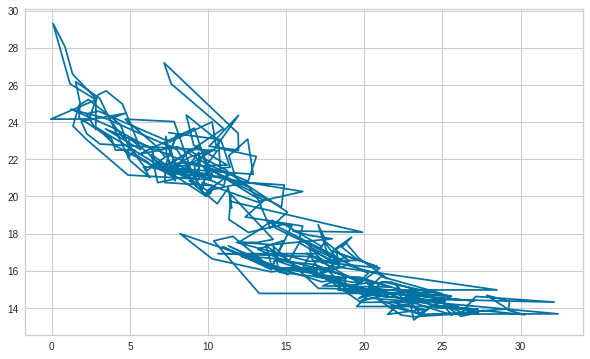

In [13]:
fig = plt.subplots(figsize =(10, 6))
plt.plot(df_days['temperatureMax'], df_days['energy'])
plt.show()
#mais frio mais energia se gasta

In [14]:
# time with int

df_days['time'] = pd.to_datetime(df_days['time'], errors='coerce')
df_days['time_int'] = df_days['time'].dt.year * 10000000000 + df_days['time'].dt.month * 100000000 + df_days['time'].dt.day * 1000000
print(df_days)

for x in splits:
    x[1]['time'] = pd.to_datetime(x[1]['time'], errors='coerce')
    x[1]['time_int'] = x[1]['time'].dt.year * 10000000000 + x[1]['time'].dt.month * 100000000 + x[1]['time'].dt.day * 1000000
    #print(x)

          time     energy  temperatureMax        time_int
0   2013-01-01  23.425315            7.49  20130101000000
1   2013-01-02  23.054733           10.82  20130102000000
2   2013-01-03  21.566103           11.41  20130103000000
3   2013-01-04  21.525555           10.79  20130104000000
4   2013-01-05  22.992247           10.66  20130105000000
..         ...        ...             ...             ...
358 2013-12-25  27.186112            7.19  20131225000000
359 2013-12-26  26.058276            7.64  20131226000000
360 2013-12-27  23.648716           10.99  20131227000000
361 2013-12-28  21.867821            7.81  20131228000000
362 2013-12-29  22.738373            7.56  20131229000000

[363 rows x 4 columns]


In [15]:
scaler = MinMaxScaler()
scaler.fit(df_days[['energy']])
df_days['s_energy'] = scaler.transform(df_days[['energy']])
scaler.fit(df_days[['time_int']])
df_days['s_time_int'] = scaler.transform(df_days[['time_int']])
scaler.fit(df_days[['temperatureMax']])
df_days['s_temperatureMax'] = scaler.transform(df_days[['temperatureMax']])

for x in splits:
    #print(x[1])
    scaler.fit(x[1][['energy']])
    x[1]['s_energy'] = scaler.transform(x[1][['energy']])
    scaler.fit(x[1][['time_int']])
    x[1]['s_time_int'] = scaler.transform(x[1][['time_int']])

    

Text(0, 0.5, 'energy')

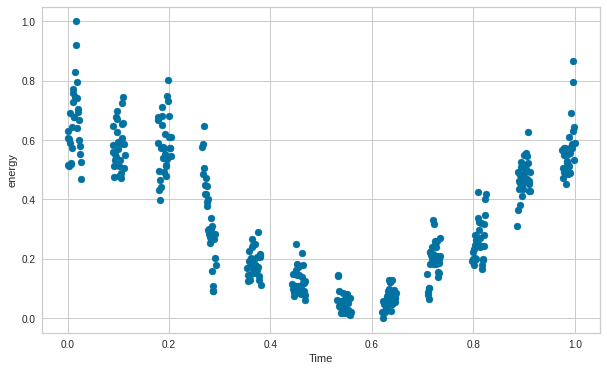

In [16]:
fig = plt.subplots(figsize =(10, 6))
plt.scatter(df_days['s_time_int'], df_days['s_energy'])
plt.xlabel('Time')
plt.ylabel('energy')

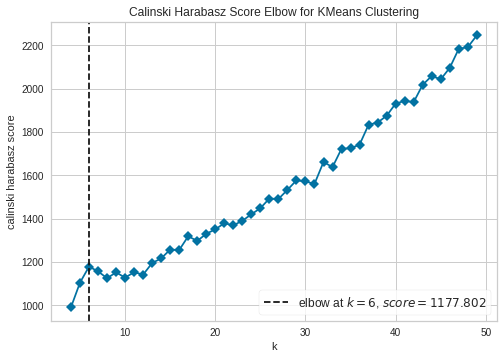

KMeans(n_clusters=49)


In [17]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(4,50), metric='calinski_harabasz', timings=False)

visualizer.fit(df_days[['s_time_int', 's_energy']])     # Fit the data to the visualizer
visualizer.show()                                # Finalize and render the figure

print(model)

In [18]:
km = KMeans(n_clusters=6)
y_predicted = km.fit_predict(df_days[['s_time_int', 's_energy']])
df_days['cluster']=y_predicted
df_days.head()

,time,energy,temperatureMax,time_int,s_energy,s_time_int,s_temperatureMax,cluster
0,2013-01-01,23.425315,7.49,20130101000000,0.631523,0.000000,0.232594,3
1,2013-01-02,23.054733,10.82,20130102000000,0.608298,0.000887,0.335182,3
2,2013-01-03,21.566103,11.41,20130103000000,0.515002,0.001773,0.353358,0
3,2013-01-04,21.525555,10.79,20130104000000,0.512461,0.002660,0.334258,0
4,2013-01-05,22.992247,10.66,20130105000000,0.604382,0.003546,0.330253,3


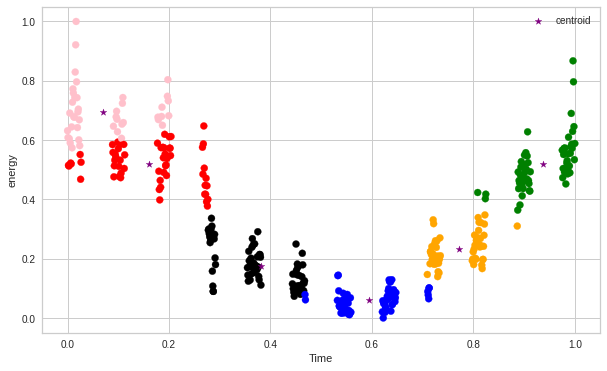

In [19]:
fig, ax = plt.subplots(figsize =(10, 6))

colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df_days['s_time_int'], df_days['s_energy'], c=df_days["cluster"].apply(lambda x: colors[x]))
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='purple',marker='*',label='centroid')
plt.xlabel('Time')
plt.ylabel('energy')
plt.legend()
plt.show()

In [20]:
nbs = NearestNeighbors()
nbs.fit(df_days[['s_time_int', 's_energy']])

NearestNeighbors()

In [21]:
"""
#distances, indexes = nbs.kneighbors(df_days[['s_time_int', 's_energy']])
for x in splits:
    d, i = nbs.kneighbors(x[1][['s_time_int', 's_energy']])
    distances = np.vstack((distances, d))
    l1 = np.append(l1, distances.mean())
    #print(d.mean())
    #print(i.mean())
    #print(distances)
    #print(indexes.mean())
    #print("=====================================================")
    
l1 = np.array(l1)    
print(np.size(distances.mean(axis=1)))
print(distances[0])
"""


'\n#distances, indexes = nbs.kneighbors(df_days[[\'s_time_int\', \'s_energy\']])\nfor x in splits:\n    d, i = nbs.kneighbors(x[1][[\'s_time_int\', \'s_energy\']])\n    distances = np.vstack((distances, d))\n    l1 = np.append(l1, distances.mean())\n    #print(d.mean())\n    #print(i.mean())\n    #print(distances)\n    #print(indexes.mean())\n    #print("=====================================================")\n    \nl1 = np.array(l1)    \nprint(np.size(distances.mean(axis=1)))\nprint(distances[0])\n'

In [22]:
"""
fig = plt.subplots(figsize =(40, 6))
plt.plot(distances.mean(axis=1))
plt.axhline(y = l1.mean(), color = 'r', linestyle = '-')
"""

"\nfig = plt.subplots(figsize =(40, 6))\nplt.plot(distances.mean(axis=1))\nplt.axhline(y = l1.mean(), color = 'r', linestyle = '-')\n"

In [23]:
"""
for x in distances:
    print(np.where(x.mean(axis=1) > 0.4))
#anb_index = np.where(distances.mean(axis=1) > 0.4)
#print(anb_index[0])
"""

'\nfor x in distances:\n    print(np.where(x.mean(axis=1) > 0.4))\n#anb_index = np.where(distances.mean(axis=1) > 0.4)\n#print(anb_index[0])\n'

In [24]:
"""
fig = plt.subplots(figsize =(10, 6))
plt.scatter(df_days['s_time_int'], df_days['s_energy'])
#plt.scatter(data['time_int'], distances, edgecolors='r')
plt.scatter(df_days['s_time_int'][anb_index[0]], df_days['s_energy'][anb_index[0]], color='r')
plt.xlabel('Time')
plt.ylabel('energy')
"""

"\nfig = plt.subplots(figsize =(10, 6))\nplt.scatter(df_days['s_time_int'], df_days['s_energy'])\n#plt.scatter(data['time_int'], distances, edgecolors='r')\nplt.scatter(df_days['s_time_int'][anb_index[0]], df_days['s_energy'][anb_index[0]], color='r')\nplt.xlabel('Time')\nplt.ylabel('energy')\n"

In [25]:
df['time_epoch'] = (df['time'].astype(np.int64)/100000000000).astype(np.int64)
df = df.dropna()
print(df.isna().sum())
data = df[['energy', 'time_epoch', 'daylight', 'DayOfTheWeek', 'WeekDay']]
print(data.isna().sum())

house           0
time            0
energy          0
daylight        0
DayOfTheWeek    0
WeekDay         0
categories      0
time_epoch      0
dtype: int64
energy          0
time_epoch      0
daylight        0
DayOfTheWeek    0
WeekDay         0
dtype: int64


In [26]:
# train isolation forest 
model =  IsolationForest(contamination = 0.02)
model.fit(data.to_numpy())
# add the data to the main 

df['anomaly25'] = pd.Series(model.predict(data.to_numpy()))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

0    2414895
1      63116
Name: anomaly25, dtype: int64


KeyError: "['time_int'] not in index"

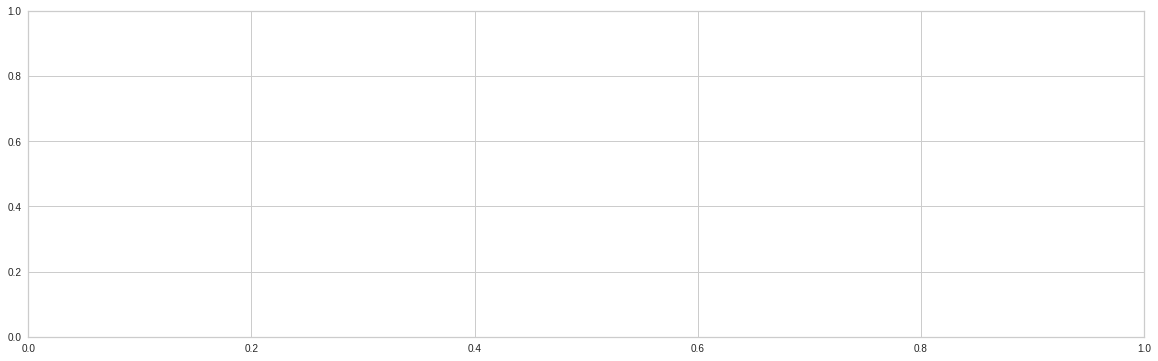

In [27]:
fig, ax = plt.subplots(figsize =(20, 6))

a = df.loc[df['anomaly25'] == 1, ['time_int', 'energy']] #anomaly

ax.plot(df['time_int'], df['energy'], color='blue')
ax.scatter(a['time_int'],a['energy'], color='red')
plt.show()